In [22]:
import numpy as np
import xroms
from glob import glob
import matplotlib.pyplot as plt
import xarray as xr
import warnings
import sys
import xrft
sys.path.append("/homes/metogra/iufarias/FeedbackSubmeso/useful/")
import romspickle
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import datetime
import cmocean as cm
# from dask.diagnostics import ProgressBar
# import dask
# dask.config.set(**{'array.slicing.split_large_chunks': True})
# from dask.distributed import Client, LocalCluster
from matplotlib.gridspec import GridSpec
import matplotlib.patheffects as PathEffects

warnings.filterwarnings("ignore")

import seawater as sw
import matplotlib.gridspec as gridspec

In [2]:
# # client = Client(n_workers=90)
# # # client = Client(cluster)

# client = Client(n_workers=30,processes=True)
# client

## Reading WRF(3D)

In [79]:
# chunks={'time_counter':1}

# varfw=xr.open_mfdataset('/data/pacific/lrenault/SASI/FULL/WRF/wrf_3D_Y2012M05.nc',data_vars='minimal')
# varfw=xr.open_mfdataset('/data/pacific/lrenault/SASI/FULL/WRF/wrf_3D_Y2012M05_DAY.nc',data_vars='minimal')
# varfw=xr.open_mfdataset('/data/pacific/lrenault/SASI/FULL/WRF/wrfout_Y2012M05.nc',data_vars='minimal')
varfw=xr.open_mfdataset('/data/pacific/lrenault/SASI/FULL/WRF/wrfout_Y2012M04.nc',data_vars='minimal')

# vartw=xr.open_mfdataset('/data/pacific/lrenault/SASI/SMTH/WRF/wrf_3D_Y2012M05.nc',data_vars='minimal')



## Reading CROCO(3D)

In [80]:
chunks={'time_counter':1}

# varf=xr.open_mfdataset('/data/pacific/lrenault/SASI/CROCO/FULL/SASI_6h_his_2012-05-01-2012-05-31.nc',
#                        data_vars='minimal',chunks=chunks)

varf=xr.open_mfdataset('/data/pacific/lrenault/SASI/CROCO/FULL/SASI_6h_his_2012-04-01-2012-04-30.nc',
                       data_vars='minimal',chunks=chunks)
# vart=xr.open_mfdataset(path + 'SMTH/SASI*2012-05*.nc',data_vars='minimal',chunks=chunks)

Converting to xroms

In [81]:
varx = varf.rename({"time_counter":"ocean_time","x_rho": "xi_rho","x_u":"xi_u","x_v":"xi_v","x_w":"xi_w",
                    "y_rho":"eta_rho","y_v":"eta_v","y_u":"eta_u","y_w":"eta_w","s_rho":"s_rho","s_w":"s_w"})
df,gf=xroms.roms_dataset(varx,Vtransform=varx.Vtransform.data)

# vary = vart.rename({"time_counter":"ocean_time","x_rho": "xi_rho","x_u":"xi_u","x_v":"xi_v",
#                     "y_rho":"eta_rho","y_v":"eta_v","y_u":"eta_u","y_w":"eta_w","s_rho":"s_rho","s_w":"s_w"})
# dt,gt=xroms.roms_dataset(vary,Vtransform=vary.Vtransform.data)

In [82]:

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 22})

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Lucida Grande']

In [83]:
import xesmf as xe
    
def regrid(var, lons, lats, which):
    # rename coords for use with xESMF
    lonkey = [coord for coord in var.coords if "nav_lon" in coord][0]
    latkey = [coord for coord in var.coords if "nav_lat" in coord][0]
    var = var.rename({lonkey: "lon", latkey: "lat"})

    # whether inputs are
    if which == "pairs":
        locstream_out = True
    elif which == "grid":
        locstream_out = False

    # set up for output
    varint = xr.Dataset({"lat": (["y", "x"], lats), "lon": (["y", "x"], lons)})

    # Calculate weights.
    regridder = xe.Regridder(var, varint, "bilinear",  locstream_out=locstream_out)

    # Perform interpolation
    varint = regridder(var, keep_attrs=True)
    return varint, regridder



In [87]:
%%time
chunks_new={'time_counter':10}

tf=varf.temp#.groupby("time_counter.dayofyear").mean()
# tf=tf.chunk(chunks=chunks_new);
tf=tf[:,100:-100,100:-200].compute();
tf=tf[:-1,1:-1,1:-1]

CPU times: user 23 s, sys: 19.1 s, total: 42.1 s
Wall time: 13.3 s


## Analysis

### Regrid (WRF to CROCO)

In [85]:
u_regrid=regrid(varfw.U.compute(),
                lons=varf.nav_lon_rho.data,
                lats=varf.nav_lat_rho.data,
                which='grid')[0]#[:,100:-100,100:-200][:,1:-1,1:-1]
v_regrid=regrid(varfw.V.compute(),
                lons=varf.nav_lon_rho.data,
                lats=varf.nav_lat_rho.data,
                which='grid')[0]#[:,100:-100,100:-200][:,1:-1,1:-1]
t_air_regrid=regrid(varfw.T.compute(),
                lons=varf.nav_lon_rho.data,
                lats=varf.nav_lat_rho.data,
                which='grid')[0]#[:,100:-100,100:-200][:,1:-1,1:-1]

Overwrite existing file: bilinear_390x301_1520x1000.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: bilinear_391x300_1520x1000.nc 
 You can set reuse_weights=True to save computing time.


In [162]:
H=((varfw['PH'] + varfw['PHB'])/9.8)
H_m=(H[:,1:].data+ H[:,:-1])/2

H_m_regrid=regrid(H_m,
                lons=varf.nav_lon_rho.data,
                lats=varf.nav_lat_rho.data,
                which='grid')[0]

Overwrite existing file: bilinear_390x300_1520x1000.nc 
 You can set reuse_weights=True to save computing time.


### Altittude From geopotential

In [164]:

Altitude=((varfw['PH'] + varfw['PHB'])/9.8)[:,:,:,:200].mean(['y_grid_M','x_grid_M'])
Altitude_m=(Altitude[:,1:].data +  Altitude[:,:-1])/2

### Windshear

In [165]:
dudz2=(u_regrid.differentiate('lev_M')/(np.gradient(H_m_regrid,axis=1)))**2 
dvdz2=(v_regrid.differentiate('lev_M')/(np.gradient(H_m_regrid,axis=1)))**2

wind_shear_regrid=dudz2+dvdz2

### Plots

Example 1

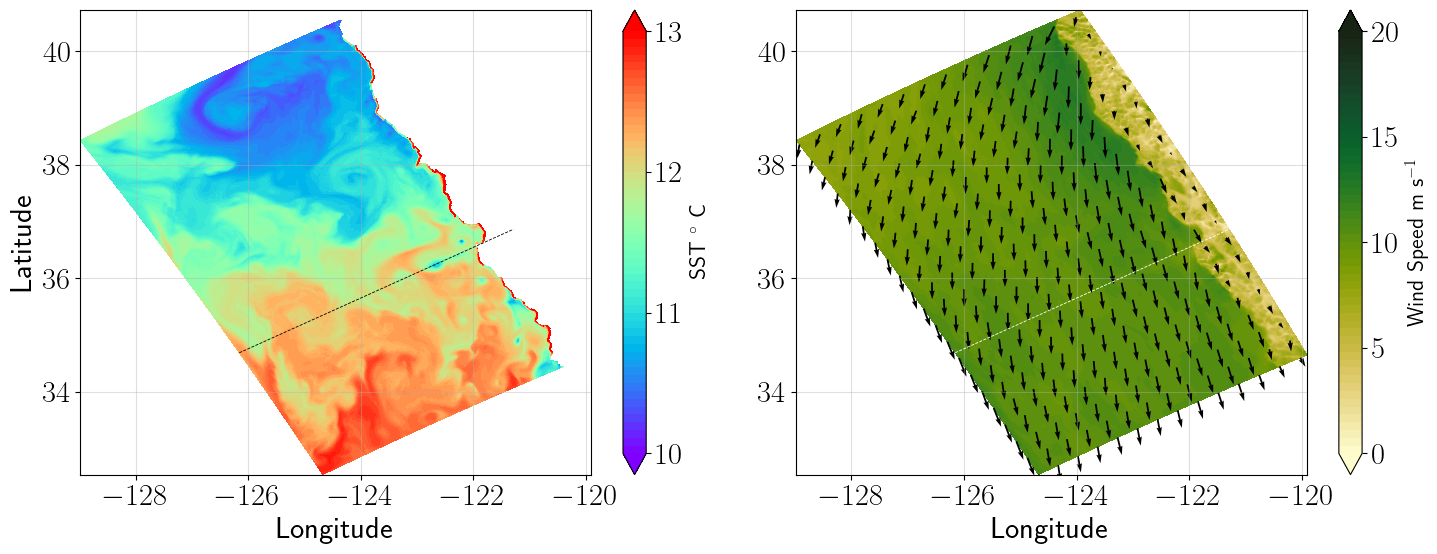

In [287]:
eta_y=550
day_t=14

# T_ocean=df['temp'].sel(ocean_time=slice(datetime.datetime(2012,5,16),datetime.datetime(2012,5,17))).mean('ocean_time')
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
T_ocean=df['temp'].sel(ocean_time=slice(datetime.datetime(2012,4,day_t),datetime.datetime(2012,4,day_t+1))).mean('ocean_time')

cc=plt.contourf(T_ocean.nav_lon_rho,T_ocean.nav_lat_rho,T_ocean[-1,:,:],
             levels=np.linspace(10,13,55),cmap='rainbow',extend='both')
cbar=plt.colorbar(cc,ticks=[10,11,12,13])
cbar.set_label(r'SST $^{\circ}$ C', fontsize=16)

plt.plot([T_ocean.isel(eta_rho=eta_y).nav_lon_rho.min().data,T_ocean.isel(eta_rho=eta_y).nav_lon_rho.max().data],
          [T_ocean.isel(eta_rho=eta_y).nav_lat_rho.min().data,T_ocean.isel(eta_rho=eta_y).nav_lat_rho.max().data],
         'k--',linewidth=0.6)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.grid(alpha=0.4)

plt.subplot(1,2,2)
Wind_map=np.sqrt(u_regrid**2+v_regrid**2).isel(time_counter=day_t-1)
dec=75
cc=plt.contourf(T_ocean.nav_lon_rho,T_ocean.nav_lat_rho,
                Wind_map[0,:,:],
             levels=np.linspace(0,20,55),cmap=cm.cm.speed,extend='both')
plt.quiver(T_ocean.nav_lon_rho[::dec,::dec],T_ocean.nav_lat_rho[::dec,::dec],
           u_regrid.isel(time_counter=day_t-1)[0,::dec,::dec],
           v_regrid.isel(time_counter=day_t-1)[0,::dec,::dec])
cbar2=plt.colorbar(cc,ticks=[0,5,10,15,20])
cbar2.set_label(r'Wind Speed m s$^{-1}$', fontsize=16)
plt.plot([T_ocean.isel(eta_rho=eta_y).nav_lon_rho.min().data,T_ocean.isel(eta_rho=eta_y).nav_lon_rho.max().data],
          [T_ocean.isel(eta_rho=eta_y).nav_lat_rho.min().data,T_ocean.isel(eta_rho=eta_y).nav_lat_rho.max().data],
         'w--',linewidth=0.6)
plt.grid(alpha=0.4)
plt.xlabel('Longitude')
# plt.ylabel('Latitude')

plt.tight_layout()

# plt.plot([T_ocean.min().data,T_ocean.xi_rho.max().data],[eta_y,eta_y],'k--')

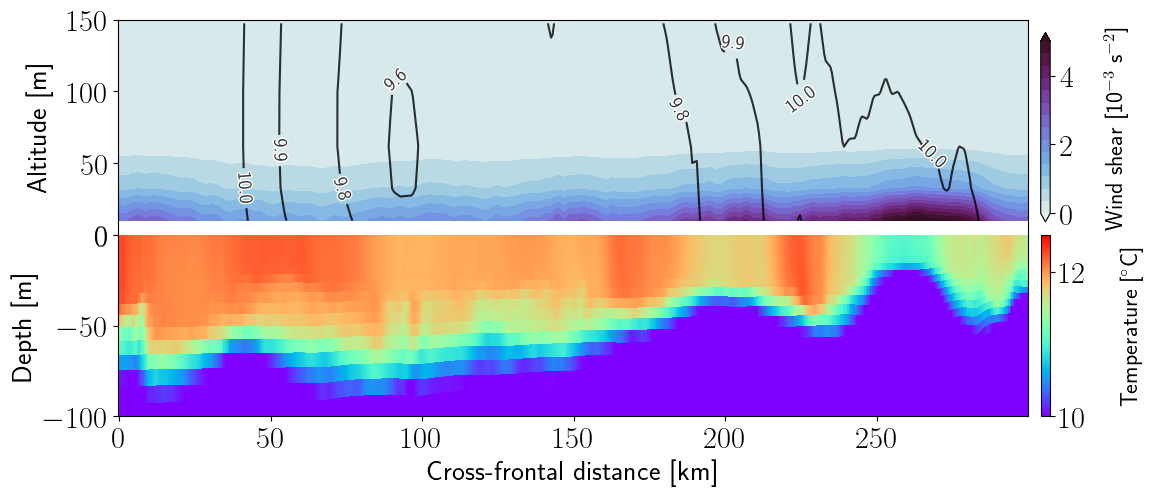

In [299]:

# eta_y=550
xi_x_min=200
xi_x_max=800
tmin=10
tmax=12.5
t_air_min=9
t_air_max=10

fig2 = plt.figure(figsize=(14, 6))
gs = GridSpec(120, 120, figure=fig2)

ax2 = fig2.add_subplot(gs[2:58,:])
alt_cut=150


# ccc=ax2.contour((t_air_regrid['x'].isel(x=slice(xi_x_min,xi_x_max))-xi_x_min)*0.5,
#                  Altitude_m.isel(time_counter=day_t-1),
#              (t_air_regrid+300-273.15).isel(time_counter=day_t-1,y=eta_y,x=slice(xi_x_min,xi_x_max)),
#              colors='k',alpha=0.8,linewidths=1.5)

ccc=ax2.contour((t_air_regrid['x'].isel(x=slice(xi_x_min,xi_x_max))-xi_x_min)*0.5,
                 Altitude_m.isel(time_counter=day_t-1,lev_W=slice(0,5)),
             (t_air_regrid+300-273.15).isel(time_counter=day_t-1,y=eta_y,x=slice(xi_x_min,xi_x_max),lev_M=slice(0,5)),
             colors='k',levels=np.linspace(t_air_min,t_air_max,9),alpha=0.8,linewidths=1.5)

cl2=ax2.clabel(ccc, ccc.levels[::1],fontsize=14,inline=True,fmt='%1.1f')
plt.setp(cl2, path_effects=[PathEffects.withStroke(linewidth=2, foreground="w")])


cc2=ax2.contourf((wind_shear_regrid['x'].isel(x=slice(xi_x_min,xi_x_max))-xi_x_min)*0.5,
                 Altitude_m.isel(time_counter=day_t-1),
             wind_shear_regrid.isel(time_counter=day_t-1,y=eta_y,x=slice(xi_x_min,xi_x_max))/1e-3,
             levels=np.linspace(0,5,15),extend='both',cmap=cm.cm.dense)


# cc2=ax2.pcolormesh((wind_shear_regrid['x'].isel(x=slice(xi_x_min,xi_x_max))-xi_x_min)*0.5,
#                    H_m_regrid.isel(time_counter=day_t-1,y=eta_y,x=slice(xi_x_min,xi_x_max)),
#              wind_shear_regrid.isel(time_counter=day_t-1,y=eta_y,x=slice(xi_x_min,xi_x_max))/1e-3,
#              vmin=0,vmax=0.5,cmap=cm.cm.dense)


cbar2=plt.colorbar(cc2,ax=ax2,ticks=[0,2,4],pad=0.012,shrink=0.88)
cbar2.set_label(label=r' Wind shear [10$^{-3}$ s$^{-2}$]', fontsize=17,labelpad=21)

y2min=5


# ax2.plot((pd.DatetimeIndex(WindCube_shear_Sec['windcube_time'])-datetime.timedelta(hours=7)),
#           np.zeros((pd.DatetimeIndex(WindCube_shear_Sec['windcube_time'])-datetime.timedelta(hours=7)).shape)+2,linestyle='--',color='k',alpha=0.2)

# ax2.set_xlim(EcoCTD_Sec.local_time[0],EcoCTD_Sec.local_time[-1])
ax2.set_xticks([])
ax2.set_ylim(0,100)
ax2.set_yticks([0,50,100,150])
ax2.set_ylabel('Altitude [m]',fontsize=20,labelpad=10)
# ax2.set_title('{0}'.format(lim[2]),loc='left')


ax2.spines['bottom'].set_visible(False)


ax3 = fig2.add_subplot(gs[58:105, :])

# cb3=plt.contourf(T_ocean.isel(eta_rho=eta_y,xi_rho=slice(xi_x_min,xi_x_max)).xi_rho,
#                  T_ocean.isel(eta_rho=eta_y,xi_rho=slice(xi_x_min,xi_x_max)).z_rho0,
#                  T_ocean.isel(eta_rho=eta_y,xi_rho=slice(xi_x_min,xi_x_max)),
#                  levels=np.linspace(10,14,55),cmap='rainbow')

cb3=plt.pcolormesh((T_ocean.isel(eta_rho=eta_y,xi_rho=slice(xi_x_min,xi_x_max)).xi_rho-xi_x_min)*0.5,
                 T_ocean.isel(eta_rho=eta_y,xi_rho=slice(xi_x_min,xi_x_max)).z_rho0,
                 T_ocean.isel(eta_rho=eta_y,xi_rho=slice(xi_x_min,xi_x_max)),
                 vmin=tmin,vmax=tmax,cmap='rainbow')

# ax2.set_xlim(EcoCTD_Sec.local_time[0],EcoCTD_Sec.local_time[-1])

cbar3=plt.colorbar(cb3,ticks=[10,12],pad=0.012)
cbar3.set_label(label=r'Temperature [$^{\circ}$C]', fontsize=17,labelpad=23)

ax3.set_ylim(-100,0)
ax3.set_ylabel('Depth [m]',fontsize=20)

ax3.set_xlabel('Cross-frontal distance [km]',fontsize=20)
# ax3.text(1,-7,'(C)')
ax3.spines['top'].set_visible(False)

Example 2

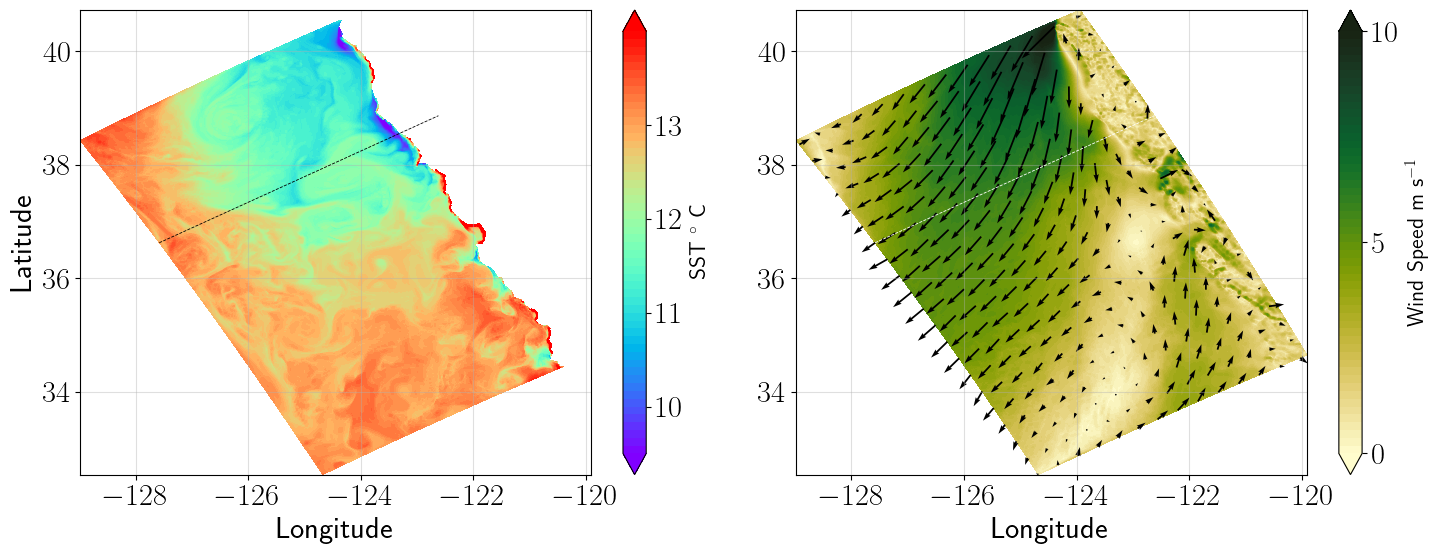

In [284]:
eta_y=1050
day_t=22


# T_ocean=df['temp'].sel(ocean_time=slice(datetime.datetime(2012,5,16),datetime.datetime(2012,5,17))).mean('ocean_time')
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
T_ocean=df['temp'].sel(ocean_time=slice(datetime.datetime(2012,4,day_t),datetime.datetime(2012,4,day_t+1))).mean('ocean_time')

cc=plt.contourf(T_ocean.nav_lon_rho,T_ocean.nav_lat_rho,T_ocean[-1,:,:],
             levels=np.linspace(9.5,14,55),cmap='rainbow',extend='both')
cbar=plt.colorbar(cc,ticks=[10,11,12,13])
cbar.set_label(r'SST $^{\circ}$ C', fontsize=16)

plt.plot([T_ocean.isel(eta_rho=eta_y).nav_lon_rho.min().data,T_ocean.isel(eta_rho=eta_y).nav_lon_rho.max().data],
          [T_ocean.isel(eta_rho=eta_y).nav_lat_rho.min().data,T_ocean.isel(eta_rho=eta_y).nav_lat_rho.max().data],
         'k--',linewidth=0.6)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.grid(alpha=0.4)

plt.subplot(1,2,2)
Wind_map=np.sqrt(u_regrid**2+v_regrid**2).isel(time_counter=day_t-1)
dec=75
cc=plt.contourf(T_ocean.nav_lon_rho,T_ocean.nav_lat_rho,
                Wind_map[0,:,:],
             levels=np.linspace(0,10,55),cmap=cm.cm.speed,extend='both')
plt.quiver(T_ocean.nav_lon_rho[::dec,::dec],T_ocean.nav_lat_rho[::dec,::dec],
           u_regrid.isel(time_counter=day_t-1)[0,::dec,::dec],
           v_regrid.isel(time_counter=day_t-1)[0,::dec,::dec])
cbar2=plt.colorbar(cc,ticks=[0,5,10])
cbar2.set_label(r'Wind Speed m s$^{-1}$', fontsize=16)
plt.plot([T_ocean.isel(eta_rho=eta_y).nav_lon_rho.min().data,T_ocean.isel(eta_rho=eta_y).nav_lon_rho.max().data],
          [T_ocean.isel(eta_rho=eta_y).nav_lat_rho.min().data,T_ocean.isel(eta_rho=eta_y).nav_lat_rho.max().data],
         'w--',linewidth=0.6)
plt.grid(alpha=0.4)
plt.xlabel('Longitude')
# plt.ylabel('Latitude')

plt.tight_layout()


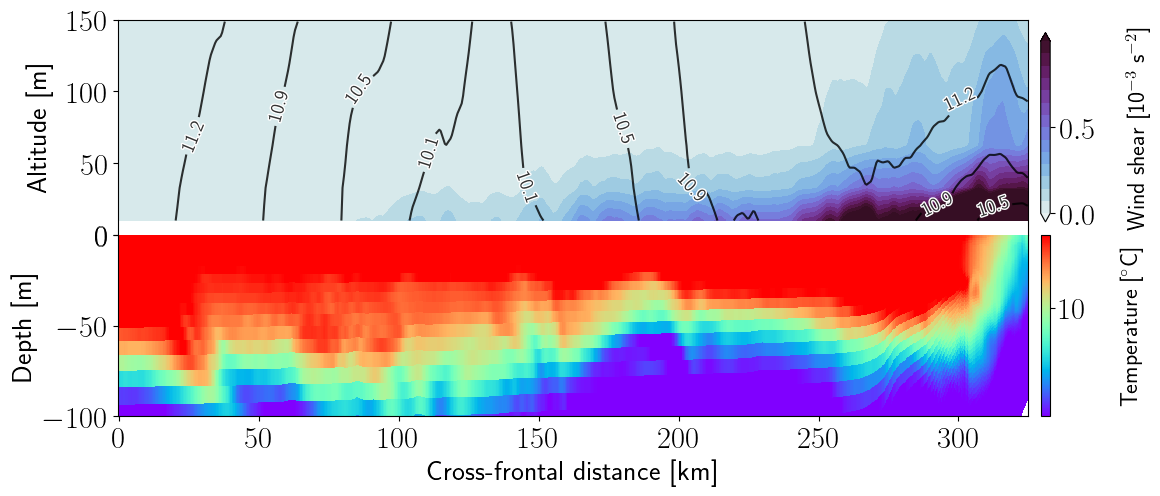

In [244]:

xi_x_min=200
xi_x_max=850
tmin=8.5
tmax=12.5
t_air_min=9
t_air_max=12

fig2 = plt.figure(figsize=(14, 6))
gs = GridSpec(120, 120, figure=fig2)

ax2 = fig2.add_subplot(gs[2:58,:])
alt_cut=150


# ccc=ax2.contour((t_air_regrid['x'].isel(x=slice(xi_x_min,xi_x_max))-xi_x_min)*0.5,
#                  Altitude_m.isel(time_counter=15),
#              (t_air_regrid+300-273.15).isel(time_counter=15,y=eta_y,x=slice(xi_x_min,xi_x_max)),
#              colors='k',alpha=0.8,linewidths=1.5)

ccc=ax2.contour((t_air_regrid['x'].isel(x=slice(xi_x_min,xi_x_max))-xi_x_min)*0.5,
                 Altitude_m.isel(time_counter=day_t,lev_W=slice(0,5)),
             (t_air_regrid+300-273.15).isel(time_counter=day_t,y=eta_y,x=slice(xi_x_min,xi_x_max),lev_M=slice(0,5)),
             colors='k',levels=np.linspace(t_air_min,t_air_max,9),alpha=0.8,linewidths=1.5)

cl2=ax2.clabel(ccc, ccc.levels[::1],fontsize=14,inline=True,fmt='%1.1f')
plt.setp(cl2, path_effects=[PathEffects.withStroke(linewidth=2, foreground="w")])


cc2=ax2.contourf((wind_shear_regrid['x'].isel(x=slice(xi_x_min,xi_x_max))-xi_x_min)*0.5,
                 Altitude_m.isel(time_counter=day_t),
             wind_shear_regrid.isel(time_counter=day_t,y=eta_y,x=slice(xi_x_min,xi_x_max))/1e-3,
             levels=np.linspace(0,1,15),extend='both',cmap=cm.cm.dense)


# cc2=ax2.pcolormesh((wind_shear_regrid['x'].isel(x=slice(xi_x_min,xi_x_max))-xi_x_min)*0.5,
#                    H_m_regrid.isel(time_counter=15,y=eta_y,x=slice(xi_x_min,xi_x_max)),
#              wind_shear_regrid.isel(time_counter=15,y=eta_y,x=slice(xi_x_min,xi_x_max))/1e-3,
#              vmin=0,vmax=0.5,cmap=cm.cm.dense)


cbar2=plt.colorbar(cc2,ax=ax2,ticks=[0,0.5],pad=0.012,shrink=0.88)
cbar2.set_label(label=r' Wind shear [10$^{-3}$ s$^{-2}$]', fontsize=17,labelpad=21)

y2min=5


# ax2.plot((pd.DatetimeIndex(WindCube_shear_Sec['windcube_time'])-datetime.timedelta(hours=7)),
#           np.zeros((pd.DatetimeIndex(WindCube_shear_Sec['windcube_time'])-datetime.timedelta(hours=7)).shape)+2,linestyle='--',color='k',alpha=0.2)

# ax2.set_xlim(EcoCTD_Sec.local_time[0],EcoCTD_Sec.local_time[-1])
ax2.set_xticks([])
ax2.set_ylim(0,100)
ax2.set_yticks([0,50,100,150])
ax2.set_ylabel('Altitude [m]',fontsize=20,labelpad=10)
# ax2.set_title('{0}'.format(lim[2]),loc='left')


ax2.spines['bottom'].set_visible(False)


ax3 = fig2.add_subplot(gs[58:105, :])

# cb3=plt.contourf(T_ocean.isel(eta_rho=eta_y,xi_rho=slice(xi_x_min,xi_x_max)).xi_rho,
#                  T_ocean.isel(eta_rho=eta_y,xi_rho=slice(xi_x_min,xi_x_max)).z_rho0,
#                  T_ocean.isel(eta_rho=eta_y,xi_rho=slice(xi_x_min,xi_x_max)),
#                  levels=np.linspace(10,14,55),cmap='rainbow')

cb3=plt.pcolormesh((T_ocean.isel(eta_rho=eta_y,xi_rho=slice(xi_x_min,xi_x_max)).xi_rho-xi_x_min)*0.5,
                 T_ocean.isel(eta_rho=eta_y,xi_rho=slice(xi_x_min,xi_x_max)).z_rho0,
                 T_ocean.isel(eta_rho=eta_y,xi_rho=slice(xi_x_min,xi_x_max)),
                 vmin=tmin,vmax=tmax,cmap='rainbow')

# ax2.set_xlim(EcoCTD_Sec.local_time[0],EcoCTD_Sec.local_time[-1])

cbar3=plt.colorbar(cb3,ticks=[10,12],pad=0.012)
cbar3.set_label(label=r'Temperature [$^{\circ}$C]', fontsize=17,labelpad=23)

ax3.set_ylim(-100,0)
ax3.set_ylabel('Depth [m]',fontsize=20)

ax3.set_xlabel('Cross-frontal distance [km]',fontsize=20)
# ax3.text(1,-7,'(C)')
ax3.spines['top'].set_visible(False)